**Note on the imported packages.** At some point, we will use Naima here, and if I understand correctly, it requires Numpy v. < 2. But I had Numpy of the version 2...! So you can either downgrade Numpy to <2, or (what my best friend ChatGPT said to do) create an environment with Numpy < 2 and Naima installed (and some other packages which do not seem to be in conflict with Numpy or Naima). If you follow the second way, ensure that this Notebook is launched from the right environment. 

But if you just want to use IBSEn for Orbit / Winds & Stars / IBS / electron evolution and NOT for specta / light curves, you're good to go without Naima.


In [1]:
import numpy as np
from numpy import sin, cos, pi
import matplotlib.pyplot as plt
import ibsen


In [2]:
from ibsen.orbit import Orbit

DAY = 86400.
AU = 1.5e13

sys_name = 'psrb' 
orb = Orbit(sys_name = sys_name, n=1003)


In [3]:
from ibsen.winds import Winds
winds = Winds(orbit=orb, sys_name = sys_name, alpha=-10/180*pi, incl=23*pi/180,
              f_d=165, f_p=0.1, delta=0.02, np_disk=3, rad_prof='pl', r_trunk=None,
             height_exp=0.25)



In [4]:
from ibsen.ibs import IBS
from ibsen.el_ev import ElectronsOnIBS
from scipy.integrate import trapezoid

t = 5 * DAY
Nibs = 41
ibs = IBS(winds=winds,
          gamma_max=3.,
          s_max=1.,
          s_max_g=4.,
          n=Nibs,
          t_to_calculate_beta_eff=t) # the same IBS as before

els = ElectronsOnIBS(
                     Bp_apex=1, # The magnetic field [G] in the Apex of the IBS coming from pulsar. Mandatory.
                     ibs=ibs, # The IBS at which the e-spec should be calculated. Mandatory.
                     cooling='adv', # How to cool the particles. Default is None.
                     to_inject_e = 'ecpl', # The injection spectrum keyword. Current options: 'ecpl' (default) or 'pl'.
                     to_inject_theta = '3d', # If '2d', then injection distribution over theta is uniform. 
                                             # If '3d' (default), then \propto sin(theta). 
    
                     ecut = 5.e12,  # Cutoff energy [eV] for ecpl. Default is 1e12.
                     p_e = 1.8, # the injection spectrum index. Default is 2.
                     to_cut_e = True, # If to set injecttion spectrum to 0 outside of the band emin < e < emax. Default is True.
                     emin = 1e9, # If to_cut_e == True, then it is the min e-energy of inj spectrum [eV]. Default is 1e9. 
                     emax = 5e14, # If to_cut_e == True, then it is the max e-energy of inj spectrum [eV]. Default is 5.1e14. 
                     norm_e = 1.e37, # the overall normalization of the injection spectrum. Default is 1e37. 
                                     # if cooling != 'no', then norm_e is treated as total number of injected e- / second.
    
                     Bs_apex=0., # The magnetic field [G] in the Apex of the IBS coming from opt. star. Default is 0.
                     eta_a = 1e20, # t_a = eta_a * dist/c. Can be either a float of None. If None, then the value
                                    # 1e20 is used. It is hardcoded that any value above 1e10 is essentially infinity,
                                    # so if you want no adiabatic losses, pass either eta_a > 1e10 or eta_a = None.
                                    #    Default is None.
    
                     eta_syn = 1., # coef before synchrotron losses term. Default is 1.
                     eta_ic = 1., # coef before IC losses term. Default is 1.
                     to_cut_theta =  False, # If to inject only at theta < where_cut_theta.
                     where_cut_theta = pi/2, # If to_cut_theta == True, then non-zero injection is only at theta < where_cut_theta.
                                             # Default if pi/2. 
                     ) 


els.calculate(to_return=False)
print('done')

done


Now it's close to finish: let's calculate the spectrum of the IBS. We know its shape, we know everything about electrons emitting, so we can calculate the Synchrotron and inverse Compton emission. This is done using \texttt{Naima} code, so you should have it installed. 
There are three modes of calculation of an SED which are controlled by two boolean keywords: `apex_only` and `simple`.
 - `apex_only=True` (any `simple`) means calculating the SED using the $B/u$ values in the IBS apex,
 - `apex_only=False`, `simple=True` means calculate SED in apex and rescale it in a simplified manner for all segments on the IBS: $\mathrm{SED}_\mathrm{Sy}(s) = \mathrm{SED}_\mathrm{Sy}(0) \times (B(s)/B(0))^2$, $\mathrm{SED}_\mathrm{IC}(s) = \mathrm{SED}_\mathrm{Sy}(0) \times u_\gamma(s)/u_\gamma(0)$.
 - `apex_only=False`, `simple=False` means iterate along the IBS and calculate the SED in every segment properly and independently.

As before, the description of all the needed parameters is given right in the Python code, but I want to comment on how the logic of the calcultion works.
- We get all parameters like magnetic and photon fields in apex and then recalculate them to every point of the IBS
- You also know the electrons spectrum $n_e(s, E)$ in the lab frame.
- If you want to: ``lorenrz_boost=True``, you can recalculate everything to the co-moving systems of frame $B\rightarrow B' = B\sqrt{\frac{2\Gamma^2+1}{3}}$, $u \rightarrow u' = u\Gamma^2 \frac{3+\beta^2}{3}$, \begin{equation}
        n(E) \rightarrow n'(E') = \frac{1}{2}\int_{-1}^1 \frac{n(E'\Gamma(1+\beta\mu'))}{\Gamma(1+\beta\mu')} d\mu'.
    \end{equation}
- Then, using either primed or not primed values, Sy+IC spectrum may be calcuated. For each $s$, \texttt{Naima} gives the SED $E'F'(E')$. It gets Doppler-boosted to the lab frame: $EF(E) = \delta^\mathrm{3~or~4} E'F'(E')\Bigg|_{E'=E/\delta}$. I am not sure what the power (3 or 4) should be of the Doppler factor $\delta = 1/(\Gamma(1-\beta \mu))$. Let's denote this power $p_\delta$. But anyay, the total spectrum is then summarized over the whole IBS:
\begin{equation}
        E F(E) = \sum_\mathrm{IBS}  (E'F'(E', s))^{\rm Naima} \times \delta_\mathrm{doppl}(s)^{p_\delta}  \Bigg|_{\nu' = \nu/\delta(s)}
\end{equation}



1.4353198597581953
Swift 0.3-10 keV flux is 2.2208515949718452e-12
H.E.S.S. 0.4-100 TeV flux is 1.2422443233481706e-11
(500,)
(500,)


Text(0.5, 0, '$\\theta$, deg')

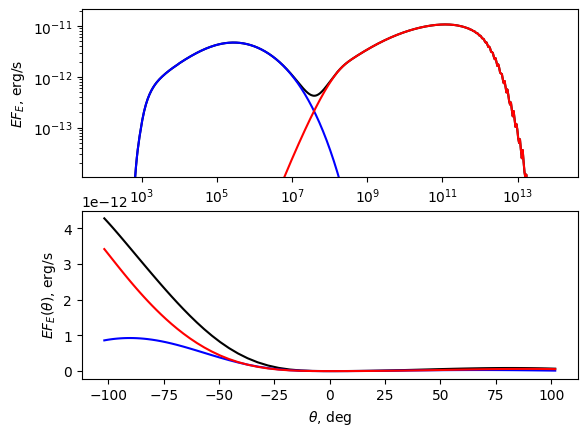

In [6]:
from ibsen.spec import SpectrumIBS
from scipy.optimize import curve_fit

def powerlaw(E, g, norm):
    return norm * E**(-g)

spec = SpectrumIBS(sys_name=sys_name, 
                   els=els, # els:ElectronsOnIBS class. Mandatory
                   simple=True, # Whether to calculate the spectrum in a simple fashion (see above). Default is False.
                   mechanisms = ['ic', 'syn'], # what nontermal mechanisms to use
                   ic_ani = False, # whether to treat IC as anisotropic. Default is False
                   apex_only=False, # Whether to employ a one-zone model. All the quantities are taken as in the apex of the IBS,
                                    # while electrons n_e = averaged over IBS. Default is False.
                   
                   delta_power=3, # The power p_delta (see above). Default is 4.
                   lorentz_boost=True, # Whether to perform Lorentz boost B, u_g, and n(s, E). Default is True.
                                       # If simple=True was set, the e-spectrum
                                       # n(s, E) will not be transformed, but the s-averaged spectrum (in lab frame) will be used instead. 
                   
                   abs_photoel=True, # Whether to include the TBabs-like photoelectric absorbtion. Default is True.
                   nh_tbabs=0.8, # If abs_photoel=True, this is the N_H (in units of 10^22) to use. Default is 0.8. 
                   abs_gg=False, # Whether to include the gamma-gamma absorbtion. Experimental feature. Uses analytical approx.
                   
                   distance = None # The distance to the system [cm]. Default is None. It will try to get the distance from the 
                                   # parameters.
                  )


E_ = np.logspace(2, 14, 500) 
(e_ph_here, # the grid of photon energies. It should be = E_, but I'm not sure hahhaaaa
 sed_here, # the total SED from IBS: 1-d array of length len(e_ph_here)
 sed_s_here # the SED from each point on IBS. 2-d array of shape (len(ibs.s), len(e_ph_here))
) = spec.calculate_sed_on_ibs(to_return=True, # If to return SED. Default is False
                                     E = E_ # On which energies to calculate the spectrum. Default is np.logspace(2, 14, 1000).
                                     )

# you can just do: spec.peek()
#### Calculate the index of the spectrum in Swift energy range. 
#### To avoid effects of absorbtion, perform fitting over (3, 10) keV.
G_ind_swift = spec.index(e1 = 3e3, e2 = 1e4)
print(G_ind_swift)
###########################################################
emissiv_s = trapezoid(spec.sed_s/e_ph_here, e_ph_here, axis=1) # The total flux from the point on IBS
emissiv_s_sy = trapezoid(spec.sed_s_sy/e_ph_here, e_ph_here, axis=1)
emissiv_s_ic = trapezoid(spec.sed_s_ic/e_ph_here, e_ph_here, axis=1)


########### Calculate fluxes in keV and TeV ranges.
fl_swift, fl_hess = spec.fluxes( bands = (
                                          [3e2, 1e4],
                                          [4e11, 1e14]
                                         )
                               )
print('Swift 0.3-10 keV flux is', fl_swift)
print('H.E.S.S. 0.4-100 TeV flux is', fl_hess)

fix, ax = plt.subplots(nrows = 2, ncols = 1)
print(spec.e_ph.shape)
print(sed_here.shape)
ax[0].plot(spec.e_ph, spec.sed, color='k')
ax[0].plot(spec.e_ph, spec.sed_sy, color='b')
ax[0].plot(spec.e_ph, spec.sed_ic, color='r')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylim(np.max(sed_here)/1e3, np.max(sed_here)*2)
ax[0].set_ylabel(r'$EF_E$, erg/s')
ax[0].set_xlabel(r'$E$, eV')


ax[1].plot(spec.els.ibs.theta_mid*180/np.pi, emissiv_s, color='k')
ax[1].plot(spec.els.ibs.theta_mid*180/np.pi, emissiv_s_sy, color='b')
ax[1].plot(spec.els.ibs.theta_mid*180/np.pi, emissiv_s_ic, color='r')

ax[1].set_ylabel(r'$EF_E(\theta)$, erg/s')
ax[1].set_xlabel(r'$\theta$, deg')

